## Dependencies

In [1]:
import udf
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import inflection

pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_rows = 30
pd.options.display.max_columns = 27

seed = 0
colors = ['#99d594', '#D53E4F', '#FC8D59']
path = "../input/"

In [16]:
full_train = udf.load_dataset(f"{path}full_train.csv")
full_train.head(2)

,accident_id,number_of_vehicles,date,day_of_week,time,road_type,speed_limit,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,postcode,number_of_casualties,accident_risk_index
0,1,2,19/12/12,7,13:20,Single carriageway,30,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,Ol or diesel,None,1,Yes,OX3 9UP,1,1.833
1,114321,1,26/04/12,4,13:30,Single carriageway,30,None within 50 metres,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Wet/Damp,None,None,1,Yes,OX3 9UP,1,1.833


## Feature Engineering

**1. Time variables**
* Parse date variable into datetime64.
* Extract the following features, year, month, day, hour, minute, hour(float) and day of year.
* Create a new feature `complete_datetime` which consists of year, month, day, hour, and minute.
* Sort the dataset by `complete_datetime`
* Apply sin-cos transformer to hour(float) to create sin and cos variable.

        

### 1. Time variables

In [35]:
def cleaned_datetime(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['time'].str.split(":").apply(lambda x: x[0]).astype(int)
    df['minute'] = df['time'].str.split(":").apply(lambda x: x[1]).astype(int)
    df['complete_datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_week'] = df['date'].dt.dayofweek + 1
    df['hour_float'] = df['hour'] + (df['minute'] / 60)
    
    return df.sort_values(by='complete_datetime').reset_index(drop=True)

full_train = cleaned_datetime(full_train)
times = [
    'date', 'day_of_week', 'time', 'year',
    'month', 'day', 'hour', 'minute',  
    'complete_datetime', 'day_of_year', 'hour_float'
]
full_train[times].head()

,date,day_of_week,time,year,month,day,hour,minute,complete_datetime,day_of_year,hour_float
0,2012-01-01,7,0:44,2012,1,1,0,44,2012-01-01 00:44:00,1,0.733
1,2012-01-01,7,1:10,2012,1,1,1,10,2012-01-01 01:10:00,1,1.167
2,2012-01-01,7,1:30,2012,1,1,1,30,2012-01-01 01:30:00,1,1.500
3,2012-01-01,7,2:20,2012,1,1,2,20,2012-01-01 02:20:00,1,2.333
4,2012-01-01,7,2:50,2012,1,1,2,50,2012-01-01 02:50:00,1,2.833


In [37]:
def sin_cos_transformer(df):
    df = df.copy()
    df['sin_hour_float'] = np.sin(2 * np.pi * df['hour_float'] / 24)
    df['cos_hour_float'] = np.cos(2 * np.pi * df['hour_float'] / 24)
    return df

full_train = sin_cos_transformer(full_train)
times = [
    'year', 'month', 'day', 'hour', 'minute',  
    'complete_datetime', 'day_of_year', 
    'hour_float', 'sin_hour_float', 'cos_hour_float'
]
full_train[times].head()

,year,month,day,hour,minute,complete_datetime,day_of_year,hour_float,sin_hour_float,cos_hour_float
0,2012,1,1,0,44,2012-01-01 00:44:00,1,0.733,0.191,0.982
1,2012,1,1,1,10,2012-01-01 01:10:00,1,1.167,0.301,0.954
2,2012,1,1,1,30,2012-01-01 01:30:00,1,1.500,0.383,0.924
3,2012,1,1,2,20,2012-01-01 02:20:00,1,2.333,0.574,0.819
4,2012,1,1,2,50,2012-01-01 02:50:00,1,2.833,0.676,0.737


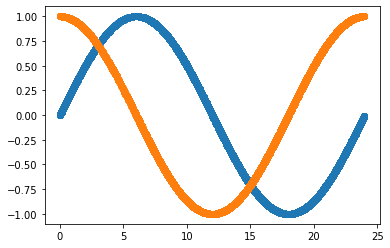

In [41]:
plt.scatter(x=full_train['hour_float'], y=full_train['sin_hour_float'])
plt.scatter(x=full_train['hour_float'], y=full_train['cos_hour_float'])
plt.show()